In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential

# Model

In [5]:
def oneIterCNN(info_ch=64, ch=128):
    ''' 
    creates the core iterated CNN block for one delta
    '''
    loss = tf.losses.BinaryCrossentropy(from_logits=True)
    model = Sequential()
    model.add(Conv2D(filters=ch, activation='relu', kernel_size=5, padding='same', input_shape=(25, 25, info_ch)))
    model.add(Conv2D(filters=ch, activation='relu', kernel_size=3, padding='same', input_shape=(25, 25, ch)))
    model.add(Conv2D(filters=info_ch, activation='relu', kernel_size=3, padding='same', input_shape=(25, 25, ch)))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
oneIterCNN().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 128)       204928    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        73792     
Total params: 426,304
Trainable params: 426,304
Non-trainable params: 0
_________________________________________________________________


In [7]:
class OneIterCNN(tf.keras.Model):
    def __init__(self, info_ch, ch):
        super(OneIterCNN, self).__init__()
        self.conv1 = Conv2D(filters=ch, activation='relu', kernel_size=5, padding='same', input_shape=(25, 25, info_ch))
        self.conv2 = Conv2D(filters=ch, activation='relu', kernel_size=3, padding='same', input_shape=(25, 25, ch))
        self.conv3 = Conv2D(filters=info_ch, activation='relu', kernel_size=3, padding='same', input_shape=(25, 25, ch))
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        return x        

In [135]:
class IterCNN(tf.keras.Model):
    def __init__(self, info_ch=64, ch=128):
        super(IterCNN, self).__init__()
        self.encoder = Conv2D(filters=64, activation = 'relu', kernel_size=7, padding='same', input_shape=(25, 25, 1))
        self.one_iter = OneIterCNN(info_ch, ch)
        self.decoder = Conv2D(filters=1, activation='relu', kernel_size=3, padding='same', input_shape=(25, 25, 64))
        
    def call(self, inputs):
        stop, delta = inputs
        x = self.encoder(stop-0.5)
        for i in range(tf.keras.backend.max(delta)):
            y = self.one_iter(x)
            # allows for different delta in the same batch
            mask = tf.keras.backend.reshape((delta > i), (-1,1,1,1))
            x = x*(tf.keras.backend.cast(~mask, 'float32')) + y*tf.keras.backend.cast(mask, 'float32')
        x = self.decoder(x)
        return x

In [136]:
loss = tf.losses.BinaryCrossentropy(from_logits=True)

model = IterCNN()

In [137]:
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

# Load Data

In [18]:
# import data
df = pd.read_csv('../data/train.csv', index_col='id')
train, val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['delta'])

# Process Data

In [55]:
def process_data(df: pd.DataFrame) -> (np.array, np.array, np.array):
    '''
    takes a dataframe of the same format as the csv loaded dataframe, extracts those boards, and 
    reshapes them to be the appropriate shape for CNN. 
    
    inputs: df is a pandas DataFrame with train data. 
    outputs: multi-dimensional np.arrays, train are the train stop boards, y_train are the train start boards, delta 
             is the number of steps required
    '''
    len_data = df.shape[0]
    delta = df.loc[:, 'delta'].values.astype('int32')
    stop_boards = df.loc[:, ['stop_{}'.format(i) for i in range(625)]].values.astype('float32').reshape(len_data, 25, 25, 1)
    start_boards = df.loc[:, ['start_{}'.format(i) for i in range(625)]].values.astype('float32').reshape(len_data, 25, 25, 1)
    return stop_boards, start_boards, delta

In [60]:
stop_train, start_train, delta_train = process_data(train)
stop_val, start_val, delta_val = process_data(val)

In [61]:
print(stop_train.shape)
print(start_train.shape)
print(delta_train.shape)
print(stop_val.shape)
print(start_val.shape)
print(delta_train.shape)

(40000, 25, 25, 1)
(40000, 25, 25, 1)
(40000,)
(10000, 25, 25, 1)
(10000, 25, 25, 1)
(40000,)


In [139]:
model.fit(x=(stop_train, delta_train), y=start_train, epochs=3, verbose=1)

Epoch 1/3
1250/1250 [==============================] - 1732s 1s/step - loss: 0.6932 - accuracy: 0.8411
Epoch 2/3
1250/1250 [==============================] - 4244s 3s/step - loss: 0.6932 - accuracy: 0.8411
Epoch 3/3
1250/1250 [==============================] - 1694s 1s/step - loss: 0.6932 - accuracy: 0.8411


# Test

In [140]:
test = pd.read_csv('../data/test.csv', index_col='id')

In [141]:
test

,delta,stop_0,stop_1,stop_2,stop_3,stop_4,stop_5,stop_6,stop_7,stop_8,...,stop_615,stop_616,stop_617,stop_618,stop_619,stop_620,stop_621,stop_622,stop_623,stop_624
id,,,,,,,,,,,,,,,,,,,,,
50000,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
50001,5,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
50002,1,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
50003,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
50004,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
def process_test_data(df: pd.DataFrame) -> (np.array, np.array, np.array):
    '''
    takes a dataframe of the same format as the test csv loaded dataframe, extracts those boards, and 
    reshapes them to be the appropriate shape for CNN. 
    
    inputs: df is a pandas DataFrame with train data. 
    outputs: multi-dimensional np.arrays, train are the train stop boards, y_train are the train start boards, delta 
             is the number of steps required
    '''
    len_data = df.shape[0]
    delta = df.loc[:, 'delta'].values.astype('int32')
    stop_boards = df.loc[:, ['stop_{}'.format(i) for i in range(625)]].values.astype('float32').reshape(len_data, 25, 25, 1)
    return stop_boards, delta

In [156]:
test_data, test_delta = process_test_data(test)

In [149]:
def compare_preds(val, y_val, model, i):
    '''
    takes the ith stop board of the val, predicts the start board of it using the CNN model and plots it. 
    Plots the actual start board for comparison
    
    Inputs: val is a np.array of validation stop boards; y_val is an np.array of validation start boards;
            model is a trained CNN model as above; i is an index, integer between 0 and len(val) - 1
    Outputs: plots the prediced board, i.e. model(val[i]) alongside the actual stop board, i.e. y_val[i]
    '''
    pred = model.predict(val)[i]
    pred = pred.reshape(25, 25)
    actual = y_val[i].reshape(25, 25)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(pred, cmap='gray_r')
    ax[0].set_title("Predicted start board")
    ax[1].imshow(actual, cmap='gray_r')
    ax[1].set_title("Actual start board")

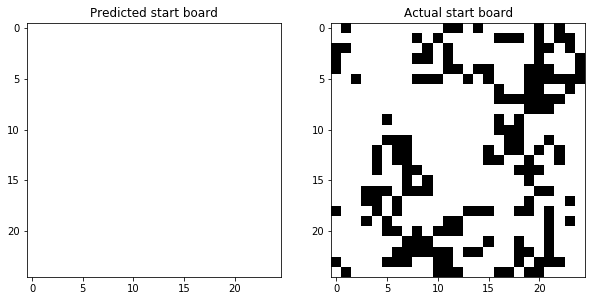

In [155]:
compare_preds((stop_val, delta_val), start_val, model, 50)

In [157]:
preds = model.predict((test_data, test_delta))

In [160]:
preds.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'